In [1]:
import numpy as np
import matplotlib.pyplot as plt
from time import sleep, time
from multiprocessing import Process, JoinableQueue, Value
import os

n= 50; m=100;            # Shape of the data input
frames= 100;               # Number of data inputs to generate
N_workers= 5;            # Numbers of instances to work on the analysis



# Simple analysis
def analyze(todo, done):
    while True:
        data= todo.get();
        sums= np.zeros(data.shape[0]);
        for i in range(data.shape[0]):
            sum= 0;
            for j in range(data.shape[1]):
                sum= sum + data[i,j];
            sums[i]= sum;
        sleep(1);         # Let's slow it down artificially
        #print('## Debug:' + str(os.getpid()) + ' analyze done\n',flush=True);
        done.put(sums);   # Instead of returning - put the result in the done queue
        todo.task_done(); # Signal that the task is done

    
# Define two queues todo and done
todo = JoinableQueue();
done = JoinableQueue();
processes = [];          # List to keep track of created processes, to be terminated at the end
frame= Value('i',0);



def collect_data(frame, done):
    count= 0;
    histograms= np.zeros(n); # Accumulate the partial results
    start= time();
    
    while True:
        taskC= done.get();
        if (len(taskC) == 0):
            np.save("analized",histograms);
            done.task_done();
            break
            
        count += 1;
        histograms= histograms + taskC;
        
        if count%1 == 0:
            now= time(); T= now-start; perf= T/count*N_workers; eta= perf*(frame.value-count)/N_workers
            H= int(T/3600); M= int((T-H*3600)/60); S= int()
            print ('Running HH:MM: {}:{:02d}    Done: {}/{}  s/frame*worker: {:.2f}s   ETA: {}:{:02d}s   \r'
                   .format(H, M, count, frame.value, perf, int(eta/60), int(eta % 60) ) , end='')
            
        if count%10 == 0:
            np.save("analized",histograms);
        done.task_done()
        
        
# Define and start processes =================================
for w in range(N_workers):
    p= Process(name="p"+str(w), target=analyze, args=(todo, done));
    processes.append(p); # Append to the process tracking list
    p.start();           # Start the defined process
    
pm= Process(name="monitor", target= collect_data, args=(frame, done))
pm.start()
    
    
# Generate random data, analyze, and collect
for i in range(frames):
    todo.put(np.random.rand(n,m));
    frame.value = frame.value + 1;
    sleep(0.1); # pretend we are slow to read/fetch/prepare data
todo.close();
    

# Wait for the workers to finish the todo and done queues ====
todo.join();
done.join();

# kill the processes
for p in processes:
    p.kill()
pm.kill()
    
# Plot the result
#plt.hist(histograms/frames, bins='auto', alpha=0.8 ,rwidth=0.85);

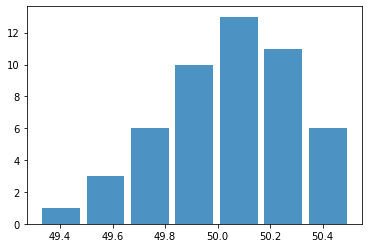

In [2]:
histograms_from_file= np.load("analized.npy")
plt.hist(histograms_from_file/frames, bins='auto', alpha=0.8 ,rwidth=0.85);

In [3]:
print(pm.is_alive(), done.qsize())

False 0
